# DA623 Project: Multi-Scale Rotation Invariant Template Matching
## - Tejas Kadre, 210102104


### rotate_image(image, angle):
- Rotates the input image by a specified angle (in degrees) around its center.
- Used to generate rotated versions of the template/image for rotation-invariant matching.

### scale_image(image, percent, maxwh):
- To scale an image by a given percentage, but ensure the scaled image does not exceed the maximum allowed width and height (maxwh).
- Scale templates or images for matching, but want to make sure they never exceed a certain display or processing size

### template_crop(image):
- This function allows the user to interactively crop a region from the input image using mouse clicks and then returns the cropped portion.
- First select the template portion then click c to finalize and move forward.

### invariant_match_template(rgbimage, rgbtemplate, method, matched_thresh, rot_range, rot_interval, scale_range, scale_interval, rm_redundant, minmax, rgbdiff_thresh=float("inf")):
- This function performs template matching that is invariant to rotation and scale using OpenCV's matchTemplate. It searches for instances of a given template image within a target image.
- rgbimage: RGB image where the search is running.
- rgbtemplate: RGB searched template. It must be not greater than the source image and have the same data type.
- method: [String] Parameter specifying the comparison method
- matched_thresh: [Float] Setting threshold of matched results(0~1).
- rot_range: [Integer] Array of range of rotation angle in degrees. Example: [0,360]
- rot_interval: [Integer] Interval of traversing the range of rotation angle in degrees.
- scale_range: [Integer] Array of range of scaling in percentage. Example: [50,200]
- scale_interval: [Integer] Interval of traversing the range of scaling in percentage.
- rm_redundant: [Boolean] Option for removing redundant matched results based on the width and height of the template.
- minmax:[Boolean] Option for finding points with minimum/maximum value.
- rgbdiff_thresh: [Float] Setting threshold of average RGB difference between template and source image. Default: +inf threshold (no rgbdiff)
- Returns a list of satisfied matched points in format [[point.x, point.y], angle, scale].

In [3]:
%pip install numpy opencv-python


import cv2
import numpy as np

box_points = []
button_down = False

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, -angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def scale_image(image, percent, maxwh):
    max_width = maxwh[1]
    max_height = maxwh[0]
    max_percent_width = max_width / image.shape[1] * 100
    max_percent_height = max_height / image.shape[0] * 100
    max_percent = 0
    if max_percent_width < max_percent_height:
        max_percent = max_percent_width
    else:
        max_percent = max_percent_height
    if percent > max_percent:
        percent = max_percent
    width = int(image.shape[1] * percent / 100)
    height = int(image.shape[0] * percent / 100)
    result = cv2.resize(image, (width, height), interpolation = cv2.INTER_AREA)
    return result, percent

def click_and_crop(event, x, y, flags, param):
    global box_points, button_down
    if (button_down == False) and (event == cv2.EVENT_LBUTTONDOWN):
        button_down = True
        box_points = [(x, y)]
    elif (button_down == True) and (event == cv2.EVENT_MOUSEMOVE):
        image_copy = param.copy()
        point = (x, y)
        cv2.rectangle(image_copy, box_points[0], point, (0, 255, 0), 2)
        cv2.imshow("Template Cropper - Press C to Crop", image_copy)
    elif event == cv2.EVENT_LBUTTONUP:
        button_down = False
        box_points.append((x, y))
        cv2.rectangle(param, box_points[0], box_points[1], (0, 255, 0), 2)
        cv2.imshow("Template Cropper - Press C to Crop", param)

# GUI template cropping tool
def template_crop(image):
    clone = image.copy()
    cv2.namedWindow("Template Cropper - Press C to Crop")
    param = image
    cv2.setMouseCallback("Template Cropper - Press C to Crop", click_and_crop, param)
    while True:
        cv2.imshow("Template Cropper - Press C to Crop", image)
        key = cv2.waitKey(1)
        if key == ord("c"):
            cv2.destroyAllWindows()
            break
    if len(box_points) == 2:
        cropped_region = clone[box_points[0][1]:box_points[1][1], box_points[0][0]:box_points[1][0]]
    return cropped_region

def invariant_match_template(rgbimage, rgbtemplate, method, matched_thresh, rot_range, rot_interval, scale_range, scale_interval, rm_redundant, minmax, rgbdiff_thresh=float("inf")):
    img_gray = cv2.cvtColor(rgbimage, cv2.COLOR_RGB2GRAY)
    template_gray = cv2.cvtColor(rgbtemplate, cv2.COLOR_RGB2GRAY)
    image_maxwh = img_gray.shape
    height, width = template_gray.shape
    all_points = []
    if minmax == False:
        for next_angle in range(rot_range[0], rot_range[1], rot_interval):
            for next_scale in range(scale_range[0], scale_range[1], scale_interval):
                scaled_template_gray, actual_scale = scale_image(template_gray, next_scale, image_maxwh)
                if next_angle == 0:
                    rotated_template = scaled_template_gray
                else:
                    rotated_template = rotate_image(scaled_template_gray, next_angle)
                if method == "TM_CCOEFF":
                    matched_points = cv2.matchTemplate(img_gray,rotated_template,cv2.TM_CCOEFF)
                    satisfied_points = np.where(matched_points >= matched_thresh)
                elif method == "TM_CCOEFF_NORMED":
                    matched_points = cv2.matchTemplate(img_gray,rotated_template,cv2.TM_CCOEFF_NORMED)
                    satisfied_points = np.where(matched_points >= matched_thresh)
                elif method == "TM_CCORR":
                    matched_points = cv2.matchTemplate(img_gray,rotated_template,cv2.TM_CCORR)
                    satisfied_points = np.where(matched_points >= matched_thresh)
                elif method == "TM_CCORR_NORMED":
                    matched_points = cv2.matchTemplate(img_gray,rotated_template,cv2.TM_CCORR_NORMED)
                    satisfied_points = np.where(matched_points >= matched_thresh)
                elif method == "TM_SQDIFF":
                    matched_points = cv2.matchTemplate(img_gray,rotated_template,cv2.TM_SQDIFF)
                    satisfied_points = np.where(matched_points <= matched_thresh)
                elif method == "TM_SQDIFF_NORMED":
                    matched_points = cv2.matchTemplate(img_gray,rotated_template,cv2.TM_SQDIFF_NORMED)
                    satisfied_points = np.where(matched_points <= matched_thresh)
                else:
                    raise MethodError("There's no such comparison method for template matching.")
                for pt in zip(*satisfied_points[::-1]):
                    all_points.append([pt, next_angle, actual_scale])
    else:
        for next_angle in range(rot_range[0], rot_range[1], rot_interval):
            for next_scale in range(scale_range[0], scale_range[1], scale_interval):
                scaled_template_gray, actual_scale = scale_image(template_gray, next_scale, image_maxwh)
                if next_angle == 0:
                    rotated_template = scaled_template_gray
                else:
                    rotated_template = rotate_image(scaled_template_gray, next_angle)
                if method == "TM_CCOEFF":
                    matched_points = cv2.matchTemplate(img_gray,rotated_template,cv2.TM_CCOEFF)
                    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(matched_points)
                    if max_val >= matched_thresh:
                        all_points.append([max_loc, next_angle, actual_scale, max_val])
                elif method == "TM_CCOEFF_NORMED":
                    matched_points = cv2.matchTemplate(img_gray,rotated_template,cv2.TM_CCOEFF_NORMED)
                    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(matched_points)
                    if max_val >= matched_thresh:
                        all_points.append([max_loc, next_angle, actual_scale, max_val])
                elif method == "TM_CCORR":
                    matched_points = cv2.matchTemplate(img_gray,rotated_template,cv2.TM_CCORR)
                    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(matched_points)
                    if max_val >= matched_thresh:
                        all_points.append([max_loc, next_angle, actual_scale, max_val])
                elif method == "TM_CCORR_NORMED":
                    matched_points = cv2.matchTemplate(img_gray,rotated_template,cv2.TM_CCORR_NORMED)
                    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(matched_points)
                    if max_val >= matched_thresh:
                        all_points.append([max_loc, next_angle, actual_scale, max_val])
                elif method == "TM_SQDIFF":
                    matched_points = cv2.matchTemplate(img_gray,rotated_template,cv2.TM_SQDIFF)
                    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(matched_points)
                    if min_val <= matched_thresh:
                        all_points.append([min_loc, next_angle, actual_scale, min_val])
                elif method == "TM_SQDIFF_NORMED":
                    matched_points = cv2.matchTemplate(img_gray,rotated_template,cv2.TM_SQDIFF_NORMED)
                    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(matched_points)
                    if min_val <= matched_thresh:
                        all_points.append([min_loc, next_angle, actual_scale, min_val])
                else:
                    raise MethodError("There's no such comparison method for template matching.")
        if method == "TM_CCOEFF":
            all_points = sorted(all_points, key=lambda x: -x[3])
        elif method == "TM_CCOEFF_NORMED":
            all_points = sorted(all_points, key=lambda x: -x[3])
        elif method == "TM_CCORR":
            all_points = sorted(all_points, key=lambda x: -x[3])
        elif method == "TM_CCORR_NORMED":
            all_points = sorted(all_points, key=lambda x: -x[3])
        elif method == "TM_SQDIFF":
            all_points = sorted(all_points, key=lambda x: x[3])
        elif method == "TM_SQDIFF_NORMED":
            all_points = sorted(all_points, key=lambda x: x[3])
    if rm_redundant == True:
        lone_points_list = []
        visited_points_list = []
        for point_info in all_points:
            point = point_info[0]
            scale = point_info[2]
            all_visited_points_not_close = True
            if len(visited_points_list) != 0:
                for visited_point in visited_points_list:
                    if ((abs(visited_point[0] - point[0]) < (width * scale / 100)) and (abs(visited_point[1] - point[1]) < (height * scale / 100))):
                        all_visited_points_not_close = False
                if all_visited_points_not_close == True:
                    lone_points_list.append(point_info)
                    visited_points_list.append(point)
            else:
                lone_points_list.append(point_info)
                visited_points_list.append(point)
        points_list = lone_points_list
    else:
        points_list = all_points
    if rgbdiff_thresh != float("inf"):
        print(">>>RGBDiff Filtering>>>")
        color_filtered_list = []
        template_channels = cv2.mean(rgbtemplate)
        template_channels = np.array([template_channels[0], template_channels[1], template_channels[2]])
        for point_info in points_list:
            point = point_info[0]
            cropped_img = rgbimage[point[1]:point[1]+height, point[0]:point[0]+width]
            cropped_channels = cv2.mean(cropped_img)
            cropped_channels = np.array([cropped_channels[0], cropped_channels[1], cropped_channels[2]])
            diff_observation = cropped_channels - template_channels
            total_diff = np.sum(np.absolute(diff_observation))
            print(total_diff)
            if total_diff < rgbdiff_thresh:
                color_filtered_list.append([point_info[0],point_info[1],point_info[2]])
        return color_filtered_list
    else:
        return points_list

Note: you may need to restart the kernel to use updated packages.


### Now visualize the template matches on the original image by drawing rotated and non-rotated rectangles at detected locations, and marking their centers.
### For each point_info in points_list:
- Extract info: 
point: top-left coordinate of matched region,
angle: rotation angle used for matching,
scale: scale factor used for matching.
- Store center info:
Calculate the center of the matched box.
Add it to centers_list for later plotting.
- Plot markers:
Red dot at center of the matched template.
Green dot at the top-left corner (actual match point).
- Draw rectangles:
rectangle: semi-transparent red rotated box showing the matched region.
box: semi-transparent green unrotated box for reference.
- Apply rotation:
Use Affine2D to rotate the red box around its center by the detected angle.
- Add to plot:
Add both red (rotated) and green (unrotated) rectangles to the plot.
Add a legend to distinguish them.
### Result:
- You get a clear visual of:
Where the template matched.
How much it was scaled and rotated.
Accurate bounding boxes showing the match orientation.
- Correctly matched with 2 objects: one rotated and one normal.


Note: you may need to restart the kernel to use updated packages.


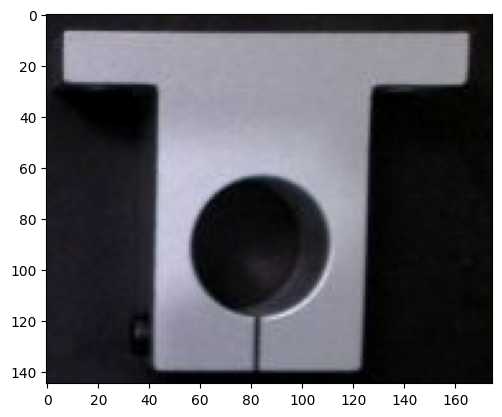

>>>RGBDiff Filtering>>>
40.25174384236453
20.16421674876848
matched point: (326, 65), angle: 0, scale: 100
matched point: (123, 82), angle: 240, scale: 100


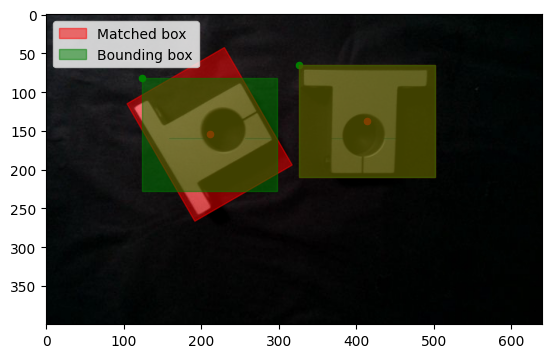

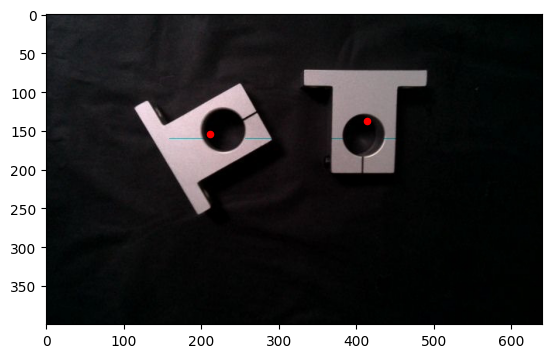

In [4]:
%pip install matplotlib
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl


if __name__ == "__main__":
    img_bgr = cv2.imread('./image_1.jpg')
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    template_bgr = plt.imread('./template_1.jpg')
    template_rgb = cv2.cvtColor(template_bgr, cv2.COLOR_BGR2RGB)
    cropped_template_rgb = template_crop(template_rgb)
    cropped_template_rgb = np.array(cropped_template_rgb)
    cropped_template_gray = cv2.cvtColor(cropped_template_rgb, cv2.COLOR_RGB2GRAY)
    height, width = cropped_template_gray.shape
    fig = plt.figure(num='Template - Close the Window to Continue >>>')
    plt.imshow(cropped_template_rgb)
    plt.show()
    points_list = invariant_match_template(rgbimage=img_rgb, rgbtemplate=cropped_template_rgb, method="TM_CCOEFF_NORMED", matched_thresh=0.5, rot_range=[0,360], rot_interval=10, scale_range=[100,150], scale_interval=10, rm_redundant=True, minmax=True, rgbdiff_thresh=215.0)
    fig, ax = plt.subplots(1)
    plt.gcf().canvas.manager.set_window_title('Template Matching Results: Rectangles')
    ax.imshow(img_rgb)
    centers_list = []
    for point_info in points_list:
        point = point_info[0]
        angle = point_info[1]
        scale = point_info[2]
        print(f"matched point: {point}, angle: {angle}, scale: {scale}")
        centers_list.append([point, scale])
        plt.scatter(point[0] + (width/2)*scale/100, point[1] + (height/2)*scale/100, s=20, color="red")
        plt.scatter(point[0], point[1], s=20, color="green")
        rectangle = patches.Rectangle((point[0], point[1]), width*scale/100, height*scale/100, color="red", alpha=0.50, label='Matched box')
        box = patches.Rectangle((point[0], point[1]), width*scale/100, height*scale/100, color="green", alpha=0.50, label='Bounding box')
        transform = mpl.transforms.Affine2D().rotate_deg_around(point[0] + width/2*scale/100, point[1] + height/2*scale/100, angle) + ax.transData
        rectangle.set_transform(transform)
        ax.add_patch(rectangle)
        ax.add_patch(box)
        plt.legend(handles=[rectangle,box])
    #plt.grid(True)
    plt.show()
    fig2, ax2 = plt.subplots(1)
    plt.gcf().canvas.manager.set_window_title('Template Matching Results: Centers')
    ax2.imshow(img_rgb)
    for point_info in centers_list:
        point = point_info[0]
        scale = point_info[1]
        plt.scatter(point[0]+width/2*scale/100, point[1]+height/2*scale/100, s=20, color="red")
    plt.show()

### Second Example
- Correctly matched with 2 objects: one rotated and one normal.

Note: you may need to restart the kernel to use updated packages.


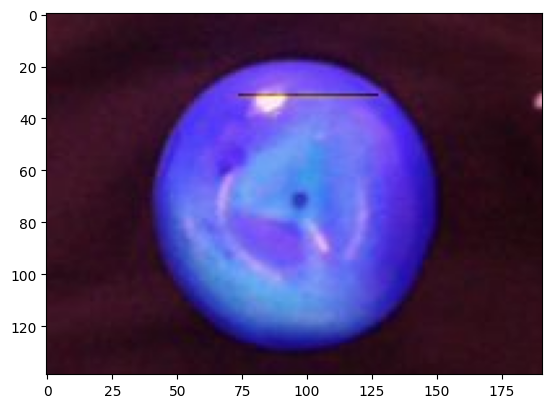

>>>RGBDiff Filtering>>>
88.20821876530191
69.28211985385514
matched point: (324, 141), angle: 0, scale: 100
matched point: (417, 2), angle: 150, scale: 100


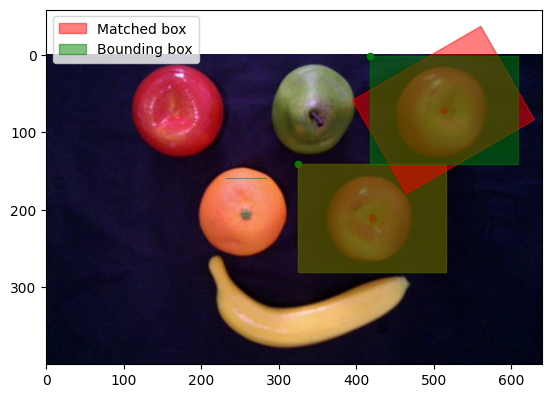

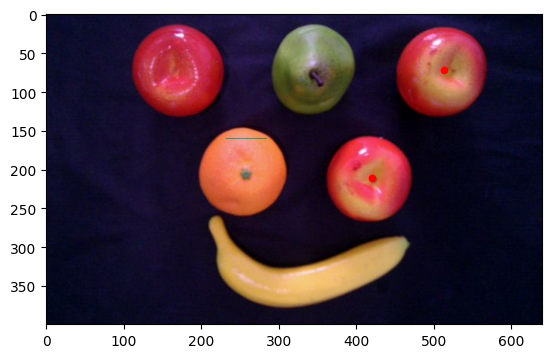

In [ ]:
%pip install matplotlib
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl


if __name__ == "__main__":
    img_bgr = cv2.imread('./image_2.jpg')
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    template_bgr = plt.imread('./template_2.jpg')
    template_rgb = cv2.cvtColor(template_bgr, cv2.COLOR_BGR2RGB)
    cropped_template_rgb = template_crop(template_rgb)
    cropped_template_rgb = np.array(cropped_template_rgb)
    cropped_template_gray = cv2.cvtColor(cropped_template_rgb, cv2.COLOR_RGB2GRAY)
    height, width = cropped_template_gray.shape
    fig = plt.figure(num='Template - Close the Window to Continue >>>')
    plt.imshow(cropped_template_rgb)
    plt.show()
    points_list = invariant_match_template(rgbimage=img_rgb, rgbtemplate=cropped_template_rgb, method="TM_CCOEFF_NORMED", matched_thresh=0.5, rot_range=[0,360], rot_interval=10, scale_range=[100,150], scale_interval=10, rm_redundant=True, minmax=True, rgbdiff_thresh=215.0)
    fig, ax = plt.subplots(1)
    plt.gcf().canvas.manager.set_window_title('Template Matching Results: Rectangles')
    ax.imshow(img_rgb)
    centers_list = []
    for point_info in points_list:
        point = point_info[0]
        angle = point_info[1]
        scale = point_info[2]
        print(f"matched point: {point}, angle: {angle}, scale: {scale}")
        centers_list.append([point, scale])
        plt.scatter(point[0] + (width/2)*scale/100, point[1] + (height/2)*scale/100, s=20, color="red")
        plt.scatter(point[0], point[1], s=20, color="green")
        rectangle = patches.Rectangle((point[0], point[1]), width*scale/100, height*scale/100, color="red", alpha=0.50, label='Matched box')
        box = patches.Rectangle((point[0], point[1]), width*scale/100, height*scale/100, color="green", alpha=0.50, label='Bounding box')
        transform = mpl.transforms.Affine2D().rotate_deg_around(point[0] + width/2*scale/100, point[1] + height/2*scale/100, angle) + ax.transData
        rectangle.set_transform(transform)
        ax.add_patch(rectangle)
        ax.add_patch(box)
        plt.legend(handles=[rectangle,box])
    #plt.grid(True)
    plt.show()
    fig2, ax2 = plt.subplots(1)
    plt.gcf().canvas.manager.set_window_title('Template Matching Results: Centers')
    ax2.imshow(img_rgb)
    for point_info in centers_list:
        point = point_info[0]
        scale = point_info[1]
        plt.scatter(point[0]+width/2*scale/100, point[1]+height/2*scale/100, s=20, color="red")
    plt.show()